In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
sys.path.append("/Users/chuck/Documents/PhD_Work/residential_testbed/model_tools/")
import utilities as u

# Part 1 
Just to load in some observed data and get into a SARS - like form

In [2]:
avail_data_path = Path.cwd().parent / "baseline_runs"
avail_data_list = list(avail_data_path.glob("*/*/eplusout.csv"))

In [3]:
def _train_models_for_single_home(model_data: Path):
    house_id = model_data.parent.name
    df_interval = u._convert_eplus_to_interval_data(model_data)
    df_training = u._convert_runtime_data_to_model_training_form(df_interval)
    _sliding_training(df_training, house_id)

def _build_reward(df: pd.DataFrame) -> None:
    heat_discomfort_ = (
        np.maximum(df["sch_heat_stp"] - df["zone_mean_air_temp_lb0"], 0) ** 2
    )
    cool_discomfort_ = (
        np.maximum(df["zone_mean_air_temp_lb0"] - df["sch_cool_stp"], 0) ** 2
    )

    df["discomfort_cost"] = heat_discomfort_ + cool_discomfort_
    df["discomfort_cost"] = df["discomfort_cost"] * -1
    
def _form_to_sarsa(df: pd.DataFrame) -> pd.DataFrame:
    key_map = {
        "zone_mean_air_temp_lb0": "s_tin_t",
        "sensible_heating_bool_lb0": "a_t_heat",
        "sensible_cooling_bool_lb0": "a_t_cool",
        "zone_mean_air_temp": "s_tin_t+1",
        "site_air_temp_lb0": "s_tout_t",
        "discomfort_cost": "r_discomfort_t",
    }

    df_sarsa = df.filter(items=key_map.keys())
    df_sarsa = df_sarsa.rename(columns=key_map)

    df_sarsa["s_heat_stp_delta_t"] = df["zone_mean_air_temp_lb0"] - df["sch_heat_stp"]
    df_sarsa["s_cool_stp_delta_t"] = df["zone_mean_air_temp_lb0"] - df["sch_cool_stp"]

    df_sarsa["s_heat_stp_delta_t"] = df_sarsa["s_heat_stp_delta_t"].round(1)
    df_sarsa["s_cool_stp_delta_t"] = df_sarsa["s_cool_stp_delta_t"].round(1)

    df_sarsa["s_heat_stp_delta_t+1"] = df_sarsa["s_heat_stp_delta_t"].shift(-1)
    df_sarsa["s_cool_stp_delta_t+1"] = df_sarsa["s_cool_stp_delta_t"].shift(-1)
    # the formation of states
    df_sarsa["s_tout_t"] = df_sarsa["s_tout_t"].apply(tout_round_to_nearest_even)

    df_sarsa["s_tin_t"] = df_sarsa["s_tin_t"].round(
        1
    )  # .apply(tin_round_to_nearest_half)
    df_sarsa["s_tin_t+1"] = df_sarsa["s_tin_t+1"].round(1)

    df_sarsa["r_t+1"] = (
        1 * df_sarsa["r_discomfort_t"].shift(-1)
        - df_sarsa["a_t_heat"]
        - df_sarsa["a_t_cool"]
    )

    df_sarsa["a_t"] = 1  # off
    df_sarsa.loc[df_sarsa["a_t_heat"] == 1, "a_t"] = 3  # heat
    df_sarsa.loc[df_sarsa["a_t_cool"] == 1, "a_t"] = 2  # cool
    return df_sarsa

def tout_round_to_nearest_even(x: float):
    return round(x / 2.0) * 2

In [4]:
df_interval = u._convert_eplus_to_interval_data(avail_data_list[0])

df_training = u._convert_runtime_data_to_model_training_form(df_interval, 2, True)
_build_reward(df_training)
df_sarsa = _form_to_sarsa(df_training)

In [5]:
df_sarsa

,s_tin_t,a_t_heat,a_t_cool,s_tin_t+1,s_tout_t,r_discomfort_t,s_heat_stp_delta_t,s_cool_stp_delta_t,s_heat_stp_delta_t+1,s_cool_stp_delta_t+1,r_t+1,a_t
2017-01-01 00:15:00,20.1,1,0,20.5,-4,-1.096258,-1.0,-2.2,-0.6,-1.7,-1.314950,3
2017-01-01 00:20:00,20.5,1,0,21.2,-6,-0.314950,-0.6,-1.7,0.1,-1.0,-1.000000,3
2017-01-01 00:25:00,21.2,0,0,21.1,-6,-0.000000,0.1,-1.0,-0.0,-1.1,-0.001506,1
2017-01-01 00:30:00,21.1,0,0,20.7,-6,-0.001506,-0.0,-1.1,-0.4,-1.5,-0.178433,1
2017-01-01 00:35:00,20.7,0,0,19.9,-6,-0.178433,-0.4,-1.5,-1.2,-2.3,-1.374626,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 23:40:00,21.2,0,0,21.2,0,-0.000000,0.0,-1.1,0.1,-1.0,-0.000000,1
2017-12-31 23:45:00,21.2,0,0,20.9,0,-0.000000,0.1,-1.0,-0.3,-1.4,-0.064518,1
2017-12-31 23:50:00,20.9,0,0,20.3,0,-0.064518,-0.3,-1.4,-0.8,-1.9,-0.704916,1
2017-12-31 23:55:00,20.3,1,0,21.2,0,-0.704916,-0.8,-1.9,0.1,-1.0,-1.000000,3


In [6]:
df_starting = df_sarsa['2017-01-01':'2017-01-15']
print(df_starting.shape)

(4317, 12)



Bad key "text.kerning_factor" on line 4 in
/Users/chuck/anaconda3/envs/py37-tensor/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


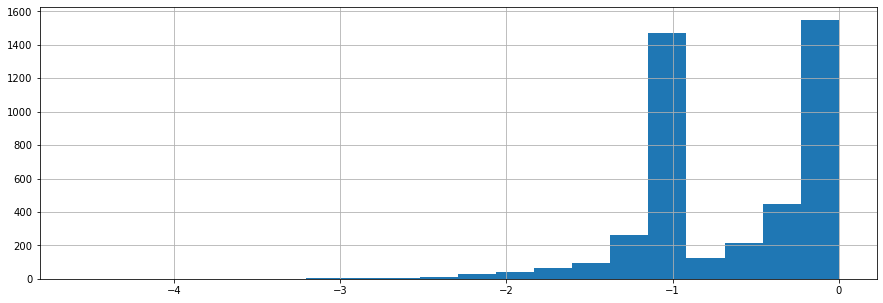

In [7]:
df_starting['r_t+1'].hist(bins=20, figsize=(15,5))

# Part 2 
Define the hist

In [8]:
import gym
import random
import os
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


class Agent():
    def __init__(self, state_size, action_size):
        self.weight_backup = "dd_weight.h5"
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.learning_rate = 0.001
        self.gamma = 0.95
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min
        return model

    def save_model(self):
        self.model.save(self.weight_backup)

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, sample_batch_size):
        if len(self.memory) < sample_batch_size:
            return
        sample_batch = random.sample(self.memory, sample_batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = reward
            if not done:
                #print(reward, next_state)
                target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape(-1,self.state_size)))
            target_f = self.model.predict(state.reshape(-1,self.state_size))
            #print(target_f, action)
            target_f[0][action] = target
            #print(state.reshape(-1,self.state_size), target_f)
            self.model.fit(state.reshape(-1,self.state_size), target_f, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

# Part 3 

Define the model and train

In [9]:
sample_batch_size = 32
episodes = 150

state_size = 2
action_size = 3
agent = Agent(state_size, action_size)
agent.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 75        
Total params: 747
Trainable params: 747
Non-trainable params: 0
_________________________________________________________________


In [10]:
# which states did we see in this training period.
# note - state 2 not observed (makes sense this is cooling)
df_starting['a_t'].value_counts()

1    2548
3    1769
Name: a_t, dtype: int64

In [11]:
# ok load up the memory buffer
for index, row in df_starting.iterrows():
    
    state = np.array([row['s_heat_stp_delta_t'],row['s_cool_stp_delta_t']])
    action =  int(row['a_t']-1)
    reward = row['r_t+1']
    next_state = np.array([row['s_heat_stp_delta_t+1'],row['s_cool_stp_delta_t+1']])
    done = False
    
    # Clip all positive rewards at 1 and all negative rewards at -1, leaving 0 rewards unchanged
    # reward = np.clip(reward, -1, 1)
    
    agent.remember(state, action, reward, next_state, done)

In [12]:
# run N episodes of a certain batch size
for _ in range(episodes):
    agent.replay(sample_batch_size)

In [13]:
# build out a test set
df_test= df_sarsa['2017-01-16':'2017-01-19']

In [14]:
# imagine i won't see any cooling again..
df_test['a_t'].value_counts()

1    615
3    537
Name: a_t, dtype: int64

In [15]:
def _choose_action_based_on_q_vals(vals:np.array)->int:
    
    #return np.where(vals == vals[vals <= 0].max())[0][0]
    return np.argmax(vals)

## what do the predictions on test look like?


In [16]:
q_vs = []
for row, data in df_test.iterrows():
    input_vals =  np.array([data["s_heat_stp_delta_t"], data["s_cool_stp_delta_t"]]).reshape(-1,2)/15.
    q_vals = agent.model.predict(input_vals)
    best_val = _choose_action_based_on_q_vals(q_vals[0])
    df_test.at[row,'q_decision'] = best_val + 1
    

/Users/chuck/anaconda3/envs/py37-tensor/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/chuck/anaconda3/envs/py37-tensor/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [17]:
df_test.head(10)

,s_tin_t,a_t_heat,a_t_cool,s_tin_t+1,s_tout_t,r_discomfort_t,s_heat_stp_delta_t,s_cool_stp_delta_t,s_heat_stp_delta_t+1,s_cool_stp_delta_t+1,r_t+1,a_t,q_decision
2017-01-16 00:00:00,21.6,0,0,20.9,-4,-0.000000,0.5,-0.6,-0.2,-1.3,-0.028987,1,2.0
2017-01-16 00:05:00,20.9,0,0,20.6,-4,-0.028987,-0.2,-1.3,-0.5,-1.7,-0.296691,1,2.0
2017-01-16 00:10:00,20.6,1,0,21.3,-4,-0.296691,-0.5,-1.7,0.2,-0.9,-1.000000,3,2.0
2017-01-16 00:15:00,21.3,0,0,21.3,-4,-0.000000,0.2,-0.9,0.2,-0.9,-0.000000,1,2.0
2017-01-16 00:20:00,21.3,0,0,20.9,-4,-0.000000,0.2,-0.9,-0.2,-1.3,-0.055419,1,2.0
2017-01-16 00:25:00,20.9,0,0,20.6,-4,-0.055419,-0.2,-1.3,-0.5,-1.6,-0.216464,1,2.0
2017-01-16 00:30:00,20.6,0,0,19.9,-4,-0.216464,-0.5,-1.6,-1.2,-2.3,-1.370898,1,2.0
2017-01-16 00:35:00,19.9,1,0,20.3,-4,-1.370898,-1.2,-2.3,-0.8,-1.9,-1.654809,3,2.0
2017-01-16 00:40:00,20.3,1,0,20.9,-4,-0.654809,-0.8,-1.9,-0.2,-1.3,-1.029593,3,2.0
2017-01-16 00:45:00,20.9,1,0,22.1,-4,-0.029593,-0.2,-1.3,1.0,-0.1,-1.000000,3,2.0


In [18]:
df_test["q_decision"].value_counts(), df_test['a_t'].value_counts()

(2.0    1152
 Name: q_decision, dtype: int64,
 1    615
 3    537
 Name: a_t, dtype: int64)

# what do the prediction on training look like?

In [19]:
q_vs = []
# should seed this for stocahstic nature

for row, data in df_starting.iterrows():
    input_vals =  np.array([data["s_heat_stp_delta_t"], data["s_cool_stp_delta_t"]]).reshape(-1,2)/15.
    q_vals = agent.model.predict(input_vals)
    best_val = _choose_action_based_on_q_vals(q_vals[0])
    df_starting.at[row,'q_decision'] = best_val + 1
    


/Users/chuck/anaconda3/envs/py37-tensor/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/chuck/anaconda3/envs/py37-tensor/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [20]:
df_starting["q_decision"].value_counts(), df_starting['a_t'].value_counts()

(2.0    4317
 Name: q_decision, dtype: int64,
 1    2548
 3    1769
 Name: a_t, dtype: int64)

In [21]:
df_starting.head(10)

,s_tin_t,a_t_heat,a_t_cool,s_tin_t+1,s_tout_t,r_discomfort_t,s_heat_stp_delta_t,s_cool_stp_delta_t,s_heat_stp_delta_t+1,s_cool_stp_delta_t+1,r_t+1,a_t,q_decision
2017-01-01 00:15:00,20.1,1,0,20.5,-4,-1.096258,-1.0,-2.2,-0.6,-1.7,-1.314950,3,2.0
2017-01-01 00:20:00,20.5,1,0,21.2,-6,-0.314950,-0.6,-1.7,0.1,-1.0,-1.000000,3,2.0
2017-01-01 00:25:00,21.2,0,0,21.1,-6,-0.000000,0.1,-1.0,-0.0,-1.1,-0.001506,1,2.0
2017-01-01 00:30:00,21.1,0,0,20.7,-6,-0.001506,-0.0,-1.1,-0.4,-1.5,-0.178433,1,2.0
2017-01-01 00:35:00,20.7,0,0,19.9,-6,-0.178433,-0.4,-1.5,-1.2,-2.3,-1.374626,1,2.0
2017-01-01 00:40:00,19.9,1,0,20.8,-6,-1.374626,-1.2,-2.3,-0.3,-1.4,-1.089070,3,2.0
2017-01-01 00:45:00,20.8,1,0,21.4,-8,-0.089070,-0.3,-1.4,0.3,-0.8,-1.000000,3,2.0
2017-01-01 00:50:00,21.4,0,0,20.7,-8,-0.000000,0.3,-0.8,-0.4,-1.5,-0.131415,1,2.0
2017-01-01 00:55:00,20.7,0,0,20.4,-8,-0.131415,-0.4,-1.5,-0.7,-1.8,-0.503345,1,2.0
2017-01-01 01:00:00,20.4,1,0,21.1,-8,-0.503345,-0.7,-1.8,0.0,-1.1,-1.000000,3,2.0


In [ ]:
# keep this here for reference

In [ ]:
class CartPole:
    def __init__(self):
        self.sample_batch_size = 32
        self.episodes = 100
        self.env = gym.make('CartPole-v1')

        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.agent = Agent(self.state_size, self.action_size)

    def run(self):
        try:
            for index_episode in range(self.episodes):
                state = self.env.reset()
                state = np.reshape(state, [1, self.state_size])

                done = False
                index = 0
                while not done:
                    #self.env.render()

                    action = self.agent.act(state)

                    next_state, reward, done, _ = self.env.step(action)
                    next_state = np.reshape(next_state, [1, self.state_size])
                    self.agent.remember(state, action, reward, next_state, done)
                    state = next_state
                    index += 1
                print("Episode {}# Score: {}".format(index_episode, index + 1))
                self.agent.replay(self.sample_batch_size)
        finally:
            self.agent.save_model()